In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math

## No lifting term

In [2]:
def compute_potential(r, sigma=0.34, epsilon=0.36):
    r_eff_sterics = r
    x = (sigma / r_eff_sterics)**6
    U_sterics = 4 * epsilon * x * (x - 1.0)
    return U_sterics



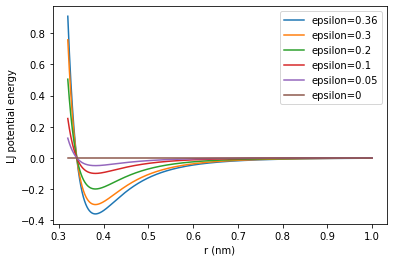

In [3]:
radii = np.linspace(0.32, 1, 1000)
energies = [compute_potential(r) for r in radii]
plt.plot(radii, energies, label=f'epsilon=0.36')
    
for epsilon in [0.3, 0.2, 0.1, 0.05, 0]:
    energies = [compute_potential(r, epsilon=epsilon) for r in radii]
    plt.plot(radii, energies, label=f'epsilon={epsilon}')

plt.legend()
plt.xlabel('r (nm)')
plt.ylabel('LJ potential energy')
plt.show()

As we decrease epsilon to 0, the "strongly repulsive" part of the potential (aka very steep part to the left of the minima in the blue curve) becomes "weakly repulsive" (see not as steep part to the left of the minima of the purple curve), making it easier for the particles to be on top of each other, which would result in a singularity.

## With lifting term

In [4]:
def compute_potential(r, w_scale, sigma=0.34, epsilon=0.36, r_cutoff=1):
    w_sterics = w_scale * r_cutoff
    r_eff_sterics = np.sqrt(r**2 + w_sterics**2)
    x = (sigma / r_eff_sterics)**6
    U_sterics = 4 * epsilon * x * (x - 1.0)
    return U_sterics


/scratch/lsftmp/4149198.tmpdir/ipykernel_73491/1770935132.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  x = (sigma / r_eff_sterics)**6


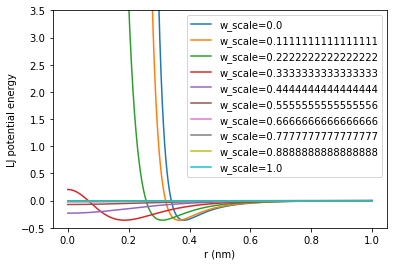

In [61]:
radii = np.linspace(0, 1, 1000)

for w_scale in np.linspace(0, 1, 10):
    energies = [compute_potential(r, w_scale) for r in radii]
    plt.plot(radii, energies, label=f'w_scale={w_scale}')

plt.legend()
plt.xlabel('r (nm)')
plt.ylabel('LJ potential energy')
plt.ylim([-0.5, 3.5])
plt.show()

For epsilon = 0.36, let's look at how different values for w_scale affect the potential. 
At small w_scale (e.g. w_scale = ~0.11), the potential looks very similar to the original but shifted to the left.
Simulataneously, the potential at r = 0 is becoming smaller, which is obvious from looking at the red curve (w_scale = 0.333).
As we increase w_scale, the potential continues shifting to the left. At a certain point, the potential at r = 0 will be at the minima. And then eventually it will become flat.
At w_scale = 1.0, the potential is flat.


/scratch/lsftmp/4149198.tmpdir/ipykernel_73491/1770935132.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  x = (sigma / r_eff_sterics)**6


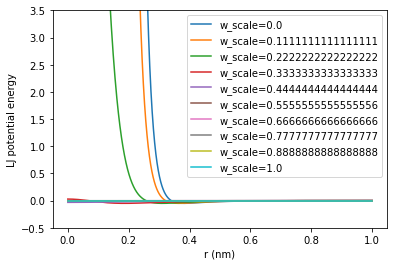

In [62]:
radii = np.linspace(0, 1, 1000)

for w_scale in np.linspace(0, 1, 10):
    energies = [compute_potential(r, w_scale, epsilon=0.05) for r in radii]
    plt.plot(radii, energies, label=f'w_scale={w_scale}')

plt.legend()
plt.xlabel('r (nm)')
plt.ylabel('LJ potential energy')
plt.ylim([-0.5, 3.5])
plt.show()

At epsilon = 0.05, let's look at how different values for w_scale affect the potential.
The potential shifts left and dramatically flattens between w_scalae 0.22 and 0.33.

## Determine better w_scale interpolation

In [97]:
functions = {"w_scale": lambda x : np.tanh(100*x) * 0.1}
             

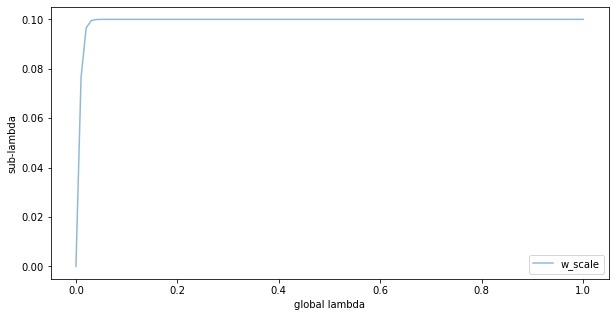

In [98]:
fig = plt.figure(figsize=(10,5))

global_lambda = np.linspace(0.,1.,100)
for f in functions:
    plt.plot(global_lambda, [functions[f](l) for l in global_lambda], alpha=0.5, label=f)

plt.xlabel('global lambda')
plt.ylabel('sub-lambda')
plt.legend()
plt.show()


In [99]:
functions = {"w_scale": lambda x : np.tanh(100*(1-x))}

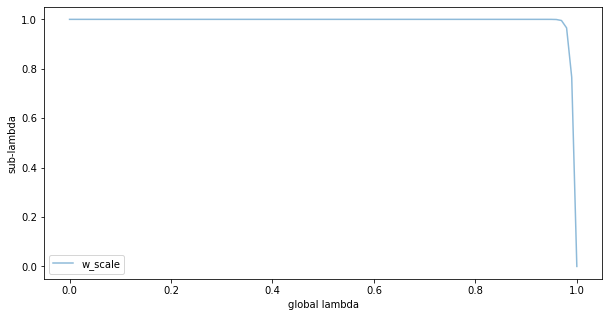

In [100]:
fig = plt.figure(figsize=(10,5))

global_lambda = np.linspace(0.,1.,100)
for f in functions:
    plt.plot(global_lambda, [functions[f](l) for l in global_lambda], alpha=0.5, label=f)

plt.xlabel('global lambda')
plt.ylabel('sub-lambda')
plt.legend()
plt.show()


The tanh(100*x) experiments didn't work. This is probably because there is a sweet spot for w_scale depending on the hamiltonian, and its not going to be the same for all of them.

## No lifting term (coulomb)

In [7]:
from openmmtools.constants import ONE_4PI_EPS0

In [18]:
0.5973*-0.5679 # C-O chargeProd

-0.33920667

In [19]:
def compute_potential(r, chargeProd=-0.33920667): 
    r_eff_electrostatics = r
    alpha = 2.918423065872431
    U_electrostatics = ONE_4PI_EPS0 * chargeProd  * math.erfc(alpha * r_eff_electrostatics)/ r_eff_electrostatics
    return U_electrostatics



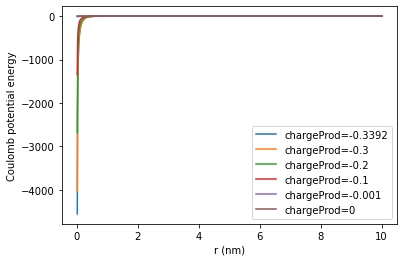

In [29]:
radii = np.linspace(0.01, 10, 1000)
energies = [compute_potential(r) for r in radii]
plt.plot(radii, energies, label='chargeProd=-0.3392')
    
for chargeProd in [-0.3, -0.2, -0.1, -0.001, 0]:
    energies = [compute_potential(r, chargeProd=chargeProd) for r in radii]
    plt.plot(radii, energies, label=f'chargeProd={chargeProd}')

plt.legend()
plt.xlabel('r (nm)')
plt.ylabel('Coulomb potential energy')
plt.show()

The reason why we don't need a lifting term in vanilla MD is because the repulsive force due to sterics is strong enough to prevent singularities in the electrostatics. However, when we are scaling charge and sigma to 0, its possible that the lifting term for sterics is not enough to prevent singularities in electrostatics, so we scale both, just in case.